# Lab 3: Bayesian PCA

### Machine Learning II, 2016

* The lab exercises should be made in groups of two people.
* The deadline for part 1 is Sunday, 15 May, 23:59.
* Assignment should be sent to taco.cohen at gmail dot com. The subject line of your email should be "[MLII2016] lab3part1_lastname1\_lastname2". 
* Put your and your teammates' names in the body of the email
* Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file follows the same rule as the subject line. For example, if the subject line is "[MLII2016] lab01\_Kingma\_Hu", the attached file should be "lab3part1\_Kingma\_Hu.ipynb". Only use underscores ("\_") to connect names, otherwise the files cannot be parsed.

Notes on implementation:

* You should write your code and answers in an IPython Notebook: http://ipython.org/notebook.html. If you have problems, please contact us.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* NOTE: test your code and make sure we can run your notebook / scripts!
* NOTE: please write your answers directly below the question in the notebook.

### Introduction

In this lab assignment, we will implement a variational algorithm for Bayesian PCA. Unlike regular PCA based on maximization of retained variance or minimization of projection error (see Bishop, 12.1.1 and 12.1.2), probabilistic PCA defines a proper density model over observed and latent variables. We will work with a fully Bayesian model this time, which is to say that we will put priors on our parameters and will be interested in learning the posterior over those parameters. Bayesian methods are very elegant, but require a shift in mindset: we are no longer looking for a point estimate of the parameters (as in maximum likelihood or MAP), but for a full posterior distribution over the space of parameters.

The integrals involved in a Bayesian analysis are usually analytically intractable, so that we must resort to approximations. In this lab assignment, we will implement the variational method described in Bishop99. Chapters 10 and 12 of the PRML book contain additional material that may be useful when doing this exercise.

* [Bishop99] Variational Principal Components, C. Bishop, ICANN 1999 - http://research.microsoft.com/pubs/67241/bishop-vpca-icann-99.pdf

Below, you will find some code to get you started.

In [1]:
%pylab inline
import scipy.special as special

class BayesianPCA(object):
    
    def __init__(self, d, N, a_alpha=10e-3, b_alpha=10e-3, a_tau=10e-3, b_tau=10e-3, beta=10e-3):
        """
        """
        self.d = d # number of dimensions
        self.N = N # number of data points
        self.q = d
        
        # Hyperparameters
        self.a_alpha = a_alpha
        self.b_alpha = b_alpha
        self.a_tau = a_tau
        self.b_tau = b_tau
        self.beta = beta

        # Variational parameters
        self.means_z = np.random.randn(d, N) # called x in bishop99
        self.sigma_z = np.random.randn(d, d)
        self.mean_mu = np.random.randn(d, 1)
        self.sigma_mu = np.random.randn(d, d)
        self.means_w = np.random.randn(d, d)
        self.sigma_w = np.random.randn(d, d)
        self.a_alpha_tilde = np.abs(np.random.randn(1))
        self.bs_alpha_tilde = np.abs(np.random.randn(d, 1))
        self.a_tau_tilde = np.abs(np.random.randn(1))
        self.b_tau_tilde = np.abs(np.random.randn(1))
    
    def __update_z(self, X):
        pass
    
    def __update_mu(self):
        pass
    
    def __update_w(self, X):
        pass
    
    def __update_alpha(self):
        pass

    def __update_tau(self, X):
        pass

    def L(self, X):
        L = 0.0
        return L
    
    def fit(self, X):
        pass

Populating the interactive namespace from numpy and matplotlib


---

$\newcommand{\vt}[1]{\mathbf{#1}}$

### 1. The Q-distribution (5 points)

In variational Bayes, we introduce a distribution $Q(\Theta)$ over parameters / latent variables in order to make inference tractable. We can think of $Q$ as being an approximation of a certain distribution. What function does $Q$ approximate, $p(D|\Theta)$, $p(\Theta|D)$, $p(D, \Theta)$, $p(\Theta)$, or $p(D)$, and how do you see that from the equation $\ln p(D) = \mathcal{L}(Q) + \mathrm{KL}(Q||P)$? (Hint: see eq. 11 in Bishop99)

#### Answer
From eq. 11 in Bishop99 we see that $Q$ is an approximation of $p(\Theta|D)$. If the function $Q(\Theta)$ is equal to $p(\Theta|D)$, the Kullback-Leibler divergence becomes zero, and so the log-marginal $\ln p(D)$ can be correctly estimated by $\mathcal{L}(Q)$. So the better $Q$ approximates the true posterior, the better the estimation given by $\mathcal{L}(Q)$ will be.

---

### 2. The mean-field approximation (15 points)

Equation 13 from [Bishop99] is a very powerful result: assuming only that $Q(\Theta)$ factorizes in a certain way (no assumptions on the functional form of the factors $Q_i$!), we get a set of coupled equations for the $Q_i$.

However, the expression given in eq. 13 for Q_i contains a small mistake. Starting with the expression for the lower bound $\mathcal{L}(Q)$, derive the correct expression (and include your derivation). You can proceed as follows: first, substitute the factorization of $Q$ (eq. 12) into the definition of $\mathcal{L}(Q)$ and separate $\mathcal{L}(Q)$ into $Q_i$-dependent and $Q_i$-independent terms. At this point, you should be able to spot the expectations $\langle\cdot\rangle_{k \neq i}$ over the other $Q$-distributions that appear in Bishop's solution (eq. 13). Now, keeping all $Q_k, k \neq i$ fixed, maximize the expression with respect to $Q_i$. You should be able to spot the form of the optimal $\ln Q_i$, from which $Q_i$ can easily be obtained.

#### Answer
\begin{align}
\mathcal{L}(Q)
&= \int Q(\Theta) \ln \frac{P(D,\Theta)}{Q(\Theta)} \mathrm{d}\Theta \\
&= \int \prod_{k}[Q_k(\theta_k)] \left\{ \ln[P(D,\Theta)] - \sum_{j}[Q_j(\theta_j)] \right\} \mathrm{d}\Theta \\
&= \int Q_j(\theta_j) \left\{ \int \ln[P(D,\Theta)] \prod_{i \neq j}  Q_i(\theta_i) d\theta_i \right\} \mathrm{d}\theta_j - \int Q_j(\theta_j) \ln[Q_j(\theta_j)] \mathrm{d}\theta_j + \text{const} \\
&= \int Q_j(\theta_j)  \ln[\tilde{p}(D,\Theta_j)] \mathrm{d}\theta_j - \int Q_j(\theta_j) \ln[Q_j(\theta_j)] \mathrm{d}\theta_j + \text{const}
\end{align}
where:
$$ \ln[\tilde{p}(D,\Theta_i)] = \langle \ln[P(D,\Theta)] \rangle_{k\neq i}  + \text{const}$$
and 
$$  \langle \ln[P(D,\Theta)] \rangle_{k\neq i} = \int \ln[P(D,\Theta)] \prod_{i \neq j}  Q_i(\theta_i) \mathrm{d}\theta_i $$

We can see that the last result of the $\mathcal{L}(Q)$ calculation is the negative KL divergence between $Q_j(\theta_j)$ and $\tilde{p}(D,\Theta_i)$. In order to maximize $\mathcal{L}(Q)$ we can minimize that KL divergence, which has optimum when $Q_j(\theta_j) = \tilde{p}(D,\Theta_i)$. This way we get a general expression for the update of $Q_j(\theta_j)$ which when normalised takes the form:
$$Q_i(\theta_i) = \frac{\exp \big\{ \langle \ln[P(D,\Theta)] \rangle_{k\neq i} \big\}}{ \int \exp \big\{ \langle \ln[P(D,\Theta)] \rangle_{k\neq i} \big\} \mathrm{d}\theta_i}$$

---

### 3. The log-probability (10 points)

Write down the log-prob of data and parameters, $\ln p(\mathbf{X}, \mathbf{Z}, \mathbf{W}, \mathbf{\alpha}, \tau, \mathbf{\mu})$, in full detail (where $\mathbf{X}$ are observed, $\mathbf{Z}$ is latent; this is different from [Bishop99] who uses $\mathbf{T}$ and $\mathbf{X}$ respectively, but $\mathbf{X}$ and $\mathbf{Z}$ are consistent with the PRML book and are more common nowadays). Could we use the log-prob to assess the convergence of the variational Bayesian PCA algorithm? If yes, how? If no, why not?

#### Answer
\begin{align}
    \ln p(\vt{X}, \vt{Z}, \vt{W}, \alpha, \tau, \mu)
    &=  p(\alpha) p(\vt{W}|\alpha) p(\tau) p(\mu)
        p(\vt{X}|\vt{Z},\vt{W}, \mu, \tau) p(\vt{Z}) \\
    &= \ln \prod_{i=1}^q \Gamma (\alpha_i|a_\alpha, b_\alpha)
        p(\vt{W}|\alpha) \Gamma (\tau|c_\tau, d_\tau)
        \mathcal{N}(\mu|\vt{0}, \beta^{-1}\vt{I})
        p(\vt{X}|\vt{Z},\vt{W}, \mu, \tau) p(\vt{Z}) \\
    &= \sum_{i=1}^q \ln \Gamma (\alpha_i|a_\alpha, b_\alpha) +
        \ln p(\vt{W}|\alpha) + \ln \Gamma (\tau|c_\tau,  d_\tau) +
        \ln \mathcal{N}(\mu|\vt{0}, \beta^{-1}\vt{I}) +
        \ln p(\vt{X}|\vt{Z},\vt{W}, \mu, \tau) + \ln p(\vt{Z}) \\
    &= \sum_{i=1}^q \ln \Gamma (\alpha_i|a_\alpha, b_\alpha) +
        \ln p(\vt{W}|\alpha) + \ln \Gamma (\tau|c_\tau,  d_\tau) +
        \ln \mathcal{N}(\mu|\vt{0}, \beta^{-1}\vt{I}) +
        \\ & \quad
        + \sum_{n=1}^N\ln p(x_n|z_n,\vt{W}, \mu, \tau) + \sum_{n=1}^N\ln p(z_n) \\
    &= \sum_{i=1}^q \ln \Gamma (\alpha_i|a_\alpha, b_\alpha) +
        \ln p(\vt{W}|\alpha) + \ln \Gamma (\tau|c_\tau,  d_\tau) +
        \ln \mathcal{N}(\mu|\vt{0}, \beta^{-1}\vt{I}) +
        \\ & \quad
        + \sum_{n=1}^N\ln \mathcal{N}(x_n|\vt{W}z_n + \mu, \tau^{-1}\vt{I}_d) + 
        \sum_{n=1}^N\ln \mathcal{N}(z_n|\vt{0}, \vt{I}_q) \\
    &= \sum_{i=1}^q \left[ a_{\alpha}\ln b_{\alpha} - \ln\Gamma(a_{\alpha}) + 
        (a_{\alpha}-1)\ln\alpha_i-b_{\alpha}\alpha_i \right] +
        \sum_{i=1}^q \left[ \frac{d}{2}(\ln\alpha_i-\ln2\pi) - \frac{1}{2}\alpha_i||\vt{w}_i||^2 \right] +
        \\ & \quad
        +c_\tau\ln d_\tau - \ln\Gamma(c_\tau) - d_\tau\tau - \frac{d}{2}\ln2\pi\beta^{-1} -
        \frac{1}{2\beta^{-1}}\mu^T\vt{I}\mu +
        \\ & \quad
        +\sum_{n=1}^N \left[ -\frac{d}{2}\ln2\pi\tau^{-1} -\frac{1}{2\tau^{-1}}
            \big( x_n - \vt{W}z_n - \mu \big)^T\vt{I}\big( x_n - \vt{W}z_n - \mu \big)
        \right] +
        \sum_{n=1}^N \left[ -\frac{d}{2}\ln 2\pi -\frac{1}{2}z_n^T\vt{I}z_n \right] \\
    &= q\left[a_\alpha\ln b_\alpha - \ln\Gamma(a_\alpha)\right] +
        (a_\alpha-1+\frac{d}{2})\sum_{i=1}^q\ln\alpha_i - b_\alpha\sum_{i=1}^q\alpha_i -
        \left( \frac{qd}{2}+\frac{qN}{2} \right)\ln2\pi - 
        \\ & \quad
        - \frac{1}{2}\sum_{i=1}^q\alpha_i||\vt{w}_i||^2 +
        c_\tau\ln d_\tau - \ln\Gamma(c_\tau) - d_\tau\tau - \frac{d}{2}\ln2\pi\beta^{-1} -
        \frac{1}{2\beta^{-1}}\mu^T\vt{I}\mu - \frac{dN}{2}\ln2\pi\tau^{-1} -
        \\ & \quad
        - \frac{1}{2\tau^{-1}}\sum_{n=1}^N\big(x_n-\vt{W}z_n-\mu\big)^T\vt{I}\big(x_n-\vt{W}z_n-\mu\big) -
        \frac{1}{2}\sum_{n=1}^N z_n^T\vt{I}z_n
\end{align}

The log-prob of data and parameters is used to compute the lower bound $\mathcal{L}(Q)$, which, as also stated in Bishop99, can be used to monitor the convergence of the variational optimization algorithm.
Moreover, at the end of optimization, the partial derivatives of the lower bound with respect to the individual parameters of the $Q$ distribution can be calculated numerically in order to see if they are indeed close to zero.

---

### 4. The lower bound $\mathcal{L}(Q)$ (25 points)

Derive an expression for the lower bound $\mathcal{L}(Q)$ of the log-prob $\ln p(X)$ for Bayesian PCA, making use of the factorization (eq. 12) and the form of the Q-distributions (eq. 16-20) as listed in [Bishop99]. Show your steps. Implement this function.

The following result may be useful:

For $x \sim \Gamma(a,b)$, we have $\langle \ln x\rangle = \ln b + \psi(a)$, where $\psi(a) = \frac{\Gamma'(a)}{\Gamma(a)}$ is the digamma function (which is implemented in numpy.special).

#### Answer


---

In [2]:
from types import MethodType


def L(self, X):
    L = 0
    for n in xrange(self.N):
        L += X[:,n].T.dot(X[:,n])
        L += X[:,n].T.dot(self.mean_mu)
        #L += dot(dot(self.means_w.T[n].T, self.means_w[:,n]), dot(self.means_z[:,n].T, self.means_z[:,n]))
        L += self.mean_mu.T.dot(X[:,n].T)
        L -= self.mean_mu.T.dot(self.means_w).dot(self.means_z[:,n])
        L += np.trace(self.sigma_mu) + self.mean_mu.T.dot(self.mean_mu)[0]
        
    L += - self.N / 2 * np.trace(self.sigma_z)
    for n in xrange(self.N):
        L += - 1/2 * self.means_z.T[n].T.dot(self.means_z.T[n])
        
    for i in xrange(self.d):
        L+= -self.d /2 * (special.digamma(self.a_alpha_tilde) - log(self.bs_alpha_tilde[i][0]) ) - \
            1/2 * (np.trace(self.sigma_w) + self.means_w.T[i].T.dot(self.means_w.T[i]))
    
    for i in xrange(self.d):
        L += (self.a_alpha - 1) * ( -log(self.bs_alpha_tilde[i][0]) + special.digamma(self.a_alpha_tilde)) - \
            self.b_alpha * (self.a_alpha_tilde / self.bs_alpha_tilde[i][0])
            
    L += - self.beta/2*(np.trace(self.sigma_mu) + self.mean_mu.T.dot(self.mean_mu)[0])
    
    L +=  -log(self.b_tau_tilde[0]) + special.digamma(self.a_tau_tilde) - (self.a_tau_tilde / self.b_tau_tilde[0])
    
    L += self.N /2 * log(linalg.det(self.sigma_z))
    
    L += (0.5)*log(linalg.det(self.sigma_mu))

    L += self.d /2 *log(linalg.det(self.sigma_w))
    
    L += self.d * (self.a_alpha_tilde + log(special.gammaln(self.a_alpha_tilde)) + \
                   (1-self.a_alpha_tilde)*special.digamma(self.a_alpha_tilde)) 
    for i in xrange(self.d):
        L += -log(self.bs_alpha_tilde[i][0])
        
    L += self.a_tau_tilde - log(self.b_tau_tilde[0]) + (1-self.a_tau_tilde) * special.digamma(self.a_tau_tilde)
    
    return L


BayesianPCA.L = MethodType(L, None, BayesianPCA)

---

### 5. Optimize variational parameters (50 points)
Implement the update equations for the Q-distributions, in the __update_XXX methods. Each update function should re-estimate the variational parameters of the Q-distribution corresponding to one group of variables (i.e. either $Z$, $\mu$, $W$, $\alpha$ or $\tau$).

Hint: if you run into numerical instabilities resulting from the gamma function use the gammaln function from numpy.special.

In [3]:
def update_z(self, X):
    E_tau = self.a_tau_tilde / self.b_tau_tilde
    E_W = self.means_w
    E_mu = self.mean_mu
    for n in xrange(self.N):
        t_n = X.T[n].reshape((self.d,1)) 
        self.means_z.T[n] = reshape(E_tau * self.sigma_z.dot(E_W.T).dot(t_n - E_mu), self.q)
    self.sigma_z = np.linalg.inv(np.identity(self.q) + E_tau*(E_W.T.dot(E_W)))

BayesianPCA.__update_z = MethodType(update_z, None, BayesianPCA)

In [4]:
def update_mu(self, X):
    E_tau = self.a_tau_tilde / self.b_tau_tilde
    E_W = self.means_w
    S = 0
    for n in range(0,self.N):
        t_n = X.T[n].reshape((self.d,1)) 
        x_n = self.means_z.T[n].reshape((self.q,1)) 
        S += t_n - E_W.dot(x_n)
    self.mean_mu = E_tau*self.sigma_mu.dot(S)
    self.sigma_mu = np.eye(self.d) / (self.beta + self.N*(self.a_tau_tilde/self.b_tau_tilde))

BayesianPCA.__update_mu = MethodType(update_mu, None, BayesianPCA)

In [5]:
def update_w(self, X):
    S = 0
    for n in xrange(self.N):
        x_n = self.means_z.T[n].reshape((self.q,1)) 
        S += self.sigma_z + x_n.dot(x_n.T)
    self.sigma_w = np.linalg.inv(diagflat(self.a_alpha_tilde / self.bs_alpha_tilde) + \
                                 (self.a_tau_tilde / self.b_tau_tilde) * (S))


    E_tau = self.a_tau_tilde / self.b_tau_tilde
    S = 0
    for k in xrange(self.d):
        mu_k = self.mean_mu[k]
        for n in xrange(self.N):
            t_n_k = X.T[n][k]
            x_n = self.means_z.T[n].reshape((self.q,1))
            S += x_n * (t_n_k - mu_k)
        self.means_w[k] = np.reshape(E_tau * self.sigma_w.dot(S), self.q)

BayesianPCA.__update_w = MethodType(update_w, None, BayesianPCA)

In [6]:
def update_alpha(self):
    self.a_alpha_tilde = self.a_alpha + self.d/2
    for i in xrange(self.q):
        self.bs_alpha_tilde[i] = self.b_alpha + (np.trace(np.cov(self.means_w)) + \
                                                 self.means_w.T[i].T.dot(self.means_w.T[i])) / 2

BayesianPCA.__update_alpha = MethodType(update_alpha, None, BayesianPCA)

In [7]:
def update_tau(self, X):
    self.a_tau_tilde = self.a_tau + self.N*self.d / 2
    A = 0
    E_W = self.means_w
    for i in xrange(self.N):
        t_n = X.T[i].reshape((self.d,1))
        x_n = self.means_z.T[i].reshape((self.q,1))
        A += t_n.T.dot(t_n) + np.trace(self.sigma_mu) + self.mean_mu.T.dot(self.mean_mu)
        A += np.trace(E_W.T.dot(E_W).dot(self.sigma_z + x_n.dot(x_n.T)))
        A += 2 * self.mean_mu.T.dot(self.means_w).dot(x_n)
        A += -2 * t_n.T.dot(self.means_w).dot(x_n) - 2 * t_n.T.dot(self.mean_mu)
    self.b_tau_tilde = self.b_tau + .5 * A

BayesianPCA.__update_tau = MethodType(update_tau, None, BayesianPCA)

### 6. Learning algorithm (10 points)
Implement the learning algorithm described in [Bishop99], i.e. iteratively optimize each of the Q-distributions holding the others fixed.

What would be a good way to track convergence of the algorithm? Implement your suggestion.

Test the algorithm on some test data drawn from a Gaussian with different variances in orthogonal directions. 

In [20]:
def fit2(self, X , iterations=1000):
    for i in xrange(iterations):
        self.__update_z(X)
        self.__update_mu(X)
        self.__update_w(X)
        self.__update_alpha()
        self.__update_tau(X)

        if i % (iterations/10) == 0:
            print "------------------------------------"
            print "Iteration : " , i
            print "Lower Bound Value : " , self.L(X)
            print "------------------------------------"
            
def fit(self, X,iterations = 1000, threshold = 1):
    self.__update_tau(X)
    L_previous = -np.inf
    L_new = -np.inf
    i = 0
    for i in range(iterations):
        self.__update_tau(X)
        self.__update_mu(X)
        self.__update_alpha()            
        self.__update_w(X)
        self.__update_z(X)  
        if i % 100 == 0:
            print "Iterations: " , i
            print "Lower Bound Value : " , self.L(X)
        i += 1
        L_previous = L_new
        L_new = self.L(X)
        if abs(L_new - L_previous) < threshold:
            print 'Break at ', i
            break
            
            
BayesianPCA.fit = MethodType(fit, None, BayesianPCA)
BayesianPCA.fit2 = MethodType(fit2, None, BayesianPCA)

In [9]:
##The following is the implemetation we found for viewing the hinton diagram of the resulting W matrix.
import pylab as pl

def _blob(x,y,area,colour):
    """
    Source: http://wiki.scipy.org/Cookbook/Matplotlib/HintonDiagrams
    Draws a square-shaped blob with the given area (< 1) at
    the given coordinates.
    """
    hs = np.sqrt(area) / 2
    xcorners = np.array([x - hs, x + hs, x + hs, x - hs])
    ycorners = np.array([y - hs, y - hs, y + hs, y + hs])
    pl.fill(xcorners, ycorners, colour, edgecolor=colour)
    
def hinton(W, maxWeight=None):
    """
    Source: http://wiki.scipy.org/Cookbook/Matplotlib/HintonDiagrams
    Draws a Hinton diagram for visualizing a weight matrix.
    Temporarily disables matplotlib interactive mode if it is on,
    otherwise this takes forever.
    """
    reenable = False
    if pl.isinteractive():
        pl.ioff()
    pl.clf()
    height, width = W.shape
    if not maxWeight:
        maxWeight = 2**np.ceil(np.log(np.max(np.abs(W)))/np.log(2))

    pl.fill(np.array([0,width,width,0]),np.array([0,0,height,height]),'gray')
    pl.axis('off')
    pl.axis('equal')
    for x in xrange(width):
        for y in xrange(height):
            _x = x+1
            _y = y+1
            w = W[y,x]
            if w > 0:
                _blob(_x - 0.5, height - _y + 0.5, min(1,w/maxWeight),'white')
            elif w < 0:
                _blob(_x - 0.5, height - _y + 0.5, min(1,-w/maxWeight),'black')
    if reenable:
        pl.ion()
    pl.show()

Iterations:  0
Lower Bound Value :  [-5286550.48311734]
Break at  13


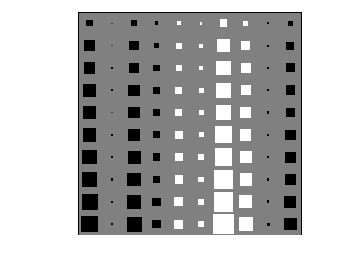

[-1539.61317625]


In [26]:
##Data Generation using numpy multivariate random. We use the same values described by [Bishop99].
X = np.random.multivariate_normal(np.zeros(10), np.diag([5,4,3,2,1,1,1,1,1,1]), 100).T

##Run Algorithm
test = BayesianPCA(10,100)
test.fit(X, iterations=50) 
hinton(test.means_w)
print test.L(X)

### 7. PCA Representation of MNIST (10 points)

Download the MNIST dataset from here http://deeplearning.net/tutorial/gettingstarted.html (the page contains python code for loading the data). Run your algorithm on (part of) this dataset, and visualize the results.
